In [1]:
#Import required packages
import pandas as pd
import numpy as np
import scipy
import warnings
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from sklearn.metrics import r2_score

In [2]:
#Generate biphasic sample data
#Input sample values
t_total = input('Total time(s)\ne.g. 120: ')
t_association = input('Time of association(s)\ne.g. 60: ')
conc = input('Concentration(M)\ne.g. 2e-7: ')
koff_1 = input('koff_1 (0<koff_1<10)\ne.g. 0.002: ')
koff_2 = input('koff_2 (0<koff_2<10)\ne.g. 0.8: ')
kon_1 = input('kon_1 (1e3<kon_1<1e8)\ne.g. 1e5: ')
kon_2 = input('kon_2 (1e3<kon_2<1e8)\ne.g. 1e7: ')
bmax_1 = input('bmax_1 (0.0<bmax_1<200.0)\ne.g. 100.0: ')
bmax_2 = input('bmax_2 (0.0<bmax_2<200.0)\ne.g. 50.0: ')

Total time(s)
e.g. 120: 120
Time of association(s)
e.g. 60: 60
Concentration(M)
e.g. 2e-7: 2e-7
koff_1 (0<koff_1<10)
e.g. 0.002: 0.002
koff_2 (0<koff_2<10)
e.g. 0.8: 0.8
kon_1 (1e3<kon_1<1e8)
e.g. 1e5: 1e5
kon_2 (1e3<kon_2<1e8)
e.g. 1e7: 1e7
bmax_1 (0.0<bmax_1<200.0)
e.g. 100.0: 100.0
bmax_2 (0.0<bmax_2<200.0)
e.g. 50.0: 50.0


In [3]:
#convert input values from 'str' to 'float'
t_total = float(t_total)
t_association = float(t_association)
conc = float(conc)
koff_1 = float(koff_1)
koff_2 = float(koff_2)
kon_1 = float(kon_1)
kon_2 = float(kon_2)
bmax_1 = float(bmax_1)
bmax_2 = float(bmax_2)

In [4]:
#Generate xData
xData = np.arange(0, t_total, 0.01)
xData_a = np.arange(0, t_association, 0.01)
xData_d = np.arange(t_association, t_total, 0.01)

In [5]:
#Generate yData for association 
yData_a = []
for xData in xData_a:
    kob_1 = kon_1*conc + koff_1
    kob_2 = kon_2*conc + koff_2
    yData_a.append(bmax_1*(1-np.exp(-kob_1*xData)) + bmax_2*(1-np.exp(-kob_2*xData)))
#Create noise for sample data
noise = np.random.normal(0, 0.2, len(xData_a))
yData_a = yData_a + noise

In [6]:
#Generate yData for dissociation
yData_d = []
for xData in xData_d:
    yData_d.append(bmax_1*np.exp(-koff_1*(xData - t_association)) + bmax_2*np.exp(-koff_2*(xData - t_association)))
#Create noise for sample data
noise = np.random.normal(0, 0.2, len(xData_d))
yData_d = yData_d + noise

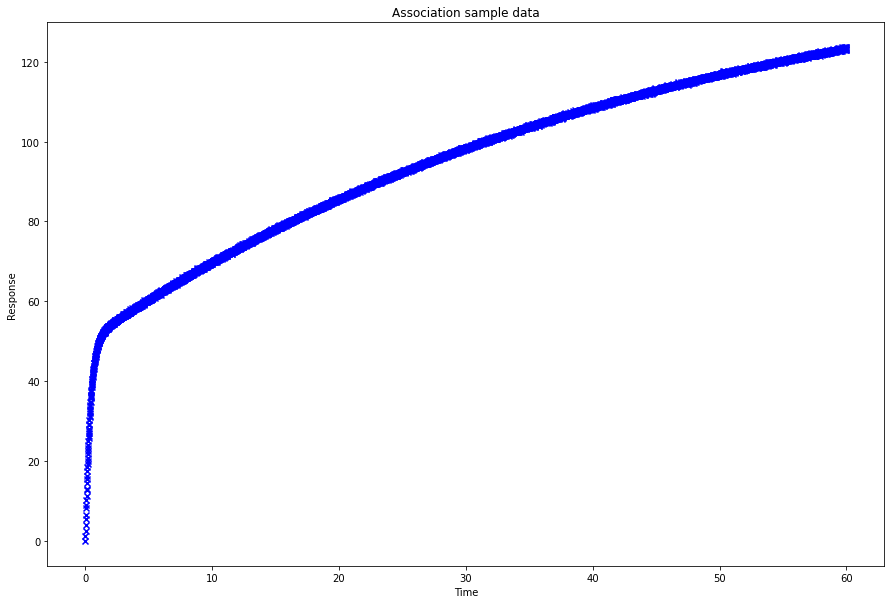

In [7]:
#Plot the sample data of association
plt.figure(figsize=(15,10))
plt.scatter(xData_a, yData_a, c = 'b', marker = 'x')
plt.xlabel('Time')
plt.ylabel('Response')
plt.title('Association sample data')
plt.show()

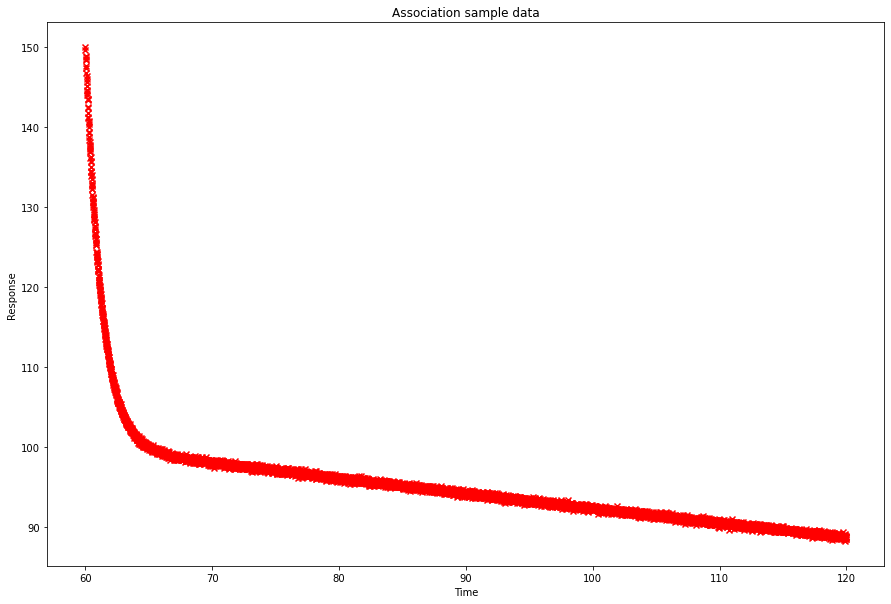

In [8]:
#Plot the sample data of dissociation
plt.figure(figsize=(15,10))
plt.scatter(xData_d, yData_d, c = 'r', marker = 'x')
plt.xlabel('Time')
plt.ylabel('Response')
plt.title('Association sample data')
plt.show()

In [9]:
#Define model functions for monophasic binding kinetics
#For monophasic dissociation
def func_MD(x, bmax, koff, shift):
    return bmax*np.exp(-koff*(x-shift))
#For monophasic association
def func_MA(x, bmax, kon, conc, koff):
    kob = kon*conc + koff
    return bmax*(1-np.exp(-kob*x))

In [10]:
#Define parameters for dissociation analysis
shift = t_association
upperbounds = max(yData_d) + 0.05*max(yData_d)

In [11]:
#Fit the curve to monophasic model and present koff value
fittedParameters_MD, pcov = curve_fit(lambda x, bmax, koff: func_MD(x, bmax, koff, shift), xData_d, yData_d, bounds = ([0.0, 0.0], [upperbounds, 10.0]), method = 'dogbox')
koff = fittedParameters_MD[1]
print('koff:', koff)

koff: 0.0030916606550385885


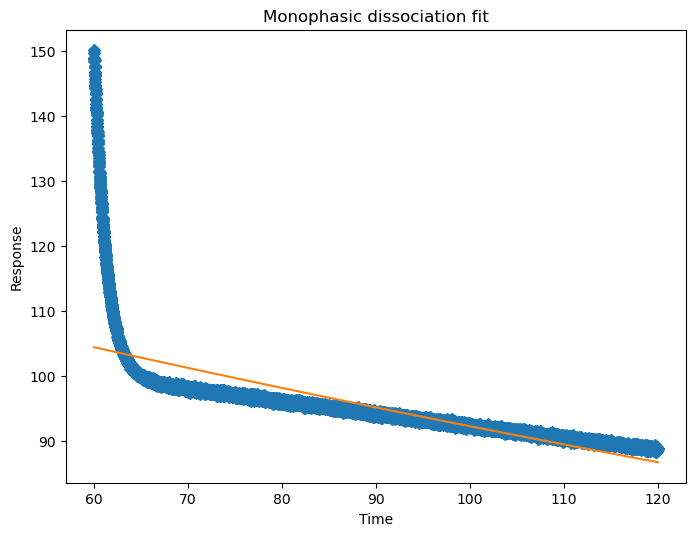

In [12]:
#Plot the graph of the fitted curve for monophasic dissociation
def ModelAndScatterPlot_MD(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData_d, yData_d,  'D', label = 'Sample data')

    # create data for the fitted equation plot
    xModel = np.linspace(min(xData_d), max(xData_d))
    yModel = func_MD(xModel, fittedParameters_MD[0], fittedParameters_MD[1], shift)

    # now the model as a line plot
    axes.plot(xModel, yModel, label = 'Fitted curve')

    axes.set_xlabel('Time') # X axis data label
    axes.set_ylabel('Response') # Y axis data label
    plt.title('Monophasic dissociation fit')

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot_MD(graphWidth, graphHeight)

In [13]:
#Fit the curve for kon value
fittedParameters_MA, pcov = curve_fit(lambda x, bmax, kon: func_MA(x, bmax, kon, conc, koff), xData_a, yData_a, bounds = ([0.0, 1e3], [upperbounds, 1e8]), method = 'dogbox')
print('kon: ', fittedParameters_MA[1])
kon = fittedParameters_MA[1]

kon:  449550.03544892365


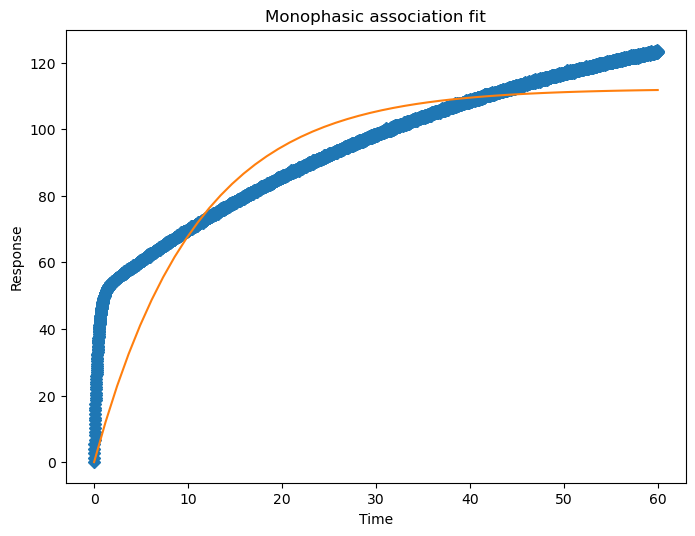

In [14]:
#Plot the fitted curve of monophasic analysis
def ModelAndScatterPlot_MA(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData_a, yData_a,  'D', label = 'Sample data')

    # create data for the fitted equation plot
    xModel = np.linspace(min(xData_a), max(xData_a))
    yModel = func_MA(xModel, fittedParameters_MA[0], fittedParameters_MA[1], conc, koff)

    # now the model as a line plot
    axes.plot(xModel, yModel, label = 'Fitted curve')

    axes.set_xlabel('Time') # X axis data label
    axes.set_ylabel('Response') # Y axis data label
    plt.title('Monophasic association fit')

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot_MA(graphWidth, graphHeight)

In [15]:
#Define model functions for biphasic binding kinetics
#For biphasic dissociation
def func_BD(x, bmax_1, koff_1, bmax_2, koff_2, shift):
    return bmax_1*np.exp(-koff_1*(x-shift)) + bmax_2*np.exp(-koff_2*(x-shift))
#For biphasic association
def func_BA(x, bmax_1, kon_1, bmax_2, kon_2, conc, koff_1, koff_2):
    kob_1 = kon_1*conc + koff_1
    kob_2 = kon_2*conc + koff_2
    return bmax_1*(1-np.exp(-kob_1*x)) + bmax_2*(1-np.exp(-kob_2*x))

In [16]:
#Fit the curve to biphasic model and present koff values
fittedParameters_BD, pcov = curve_fit(lambda x, bmax_1, koff_1, bmax_2, koff_2: func_BD(x, bmax_1, koff_1, bmax_2, koff_2, shift), xData_d, yData_d, bounds = ([0.0, 0.0, 0.0, 0.0], [upperbounds, 10.0, upperbounds, 10.0]), method = 'dogbox')
koff_1 = fittedParameters_BD[1]
koff_2 = fittedParameters_BD[3]
print('koff_1:', koff_1)
print('koff_2:', koff_2)

koff_1: 0.0020016810390825913
koff_2: 0.8000933318249691


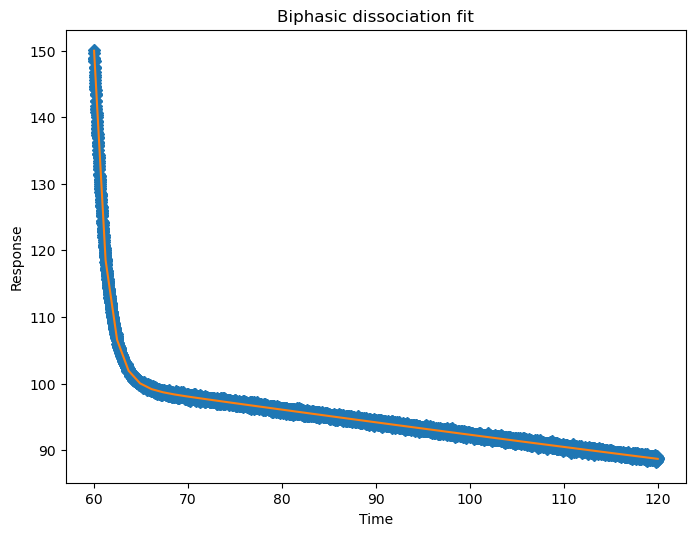

In [17]:
#Plot the graph of the fitted curve for biphasic dissociation
def ModelAndScatterPlot_BD(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData_d, yData_d,  'D', label = 'Sample data')

    # create data for the fitted equation plot
    xModel = np.linspace(min(xData_d), max(xData_d))
    yModel = func_BD(xModel, fittedParameters_BD[0], fittedParameters_BD[1], fittedParameters_BD[2], fittedParameters_BD[3], shift)

    # now the model as a line plot
    axes.plot(xModel, yModel, label = 'Fitted curve')

    axes.set_xlabel('Time') # X axis data label
    axes.set_ylabel('Response') # Y axis data label
    plt.title('Biphasic dissociation fit')

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot_BD(graphWidth, graphHeight)

In [18]:
#Fit the curve for kon values
#Adjust the limits for kon values if not fitted well(e.g. extend to 1e9)
fittedParameters_BA, pcov = curve_fit(lambda x, bmax_1, kon_1, bmax_2, kon_2: func_BA(x, bmax_1, kon_1, bmax_2, kon_2, conc, koff_1, koff_2), xData_a, yData_a, bounds = ([0.0, 1e3, 0.0, 1e3], [upperbounds, 1e8, upperbounds, 1e8]), method = 'dogbox')
kon_1 = fittedParameters_BA[1]
kon_2 = fittedParameters_BA[3]
print('kon_1: ', kon_1)
print('kon_2: ', kon_2)

kon_1:  100041.2520556412
kon_2:  9989795.580622548


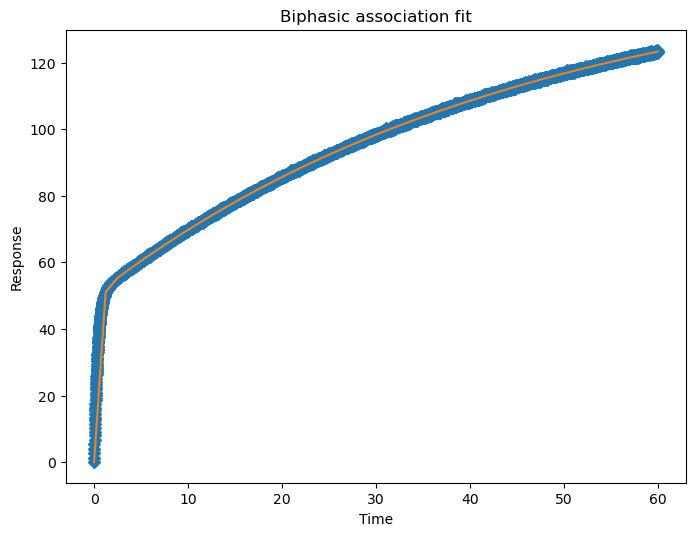

In [19]:
#Plot the graph of the fitted curve for biphasic association
def ModelAndScatterPlot_BA(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData_a, yData_a,  'D', label = 'Sample data')

    # create data for the fitted equation plot
    xModel = np.linspace(min(xData_a), max(xData_a))
    yModel = func_BA(xModel, fittedParameters_BA[0], fittedParameters_BA[1], fittedParameters_BA[2], fittedParameters_BA[3], conc, koff_1, koff_2)

    # now the model as a line plot
    axes.plot(xModel, yModel, label = 'Fitted curve')

    axes.set_xlabel('Time') # X axis data label
    axes.set_ylabel('Response') # Y axis data label
    plt.title('Biphasic association fit')

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot_BA(graphWidth, graphHeight)